### Preparation

In [10]:
### Count categories by source (real vs generated)

# Parse expected labels
log_df['expected_labels_list'] = log_df['expected_labels'].apply(
    lambda x: json.loads(x) if pd.notna(x) and x != '' else []
)

# Create string versions for grouping (sorted for consistency)
log_df['expected_labels_str'] = log_df['expected_labels_list'].apply(
    lambda x: json.dumps(sorted(x)) if x else "[]"
)

# Count by source and label combination
breakdown = log_df.groupby(['source', 'expected_labels_str']).size().reset_index(name='count')

# Create summary table
print("\n" + "="*70)
print("CATEGORY BREAKDOWN BY SOURCE")
print("="*70)

summary_data = []
for label_str in sorted(breakdown['expected_labels_str'].unique()):
    label_list = json.loads(label_str)
    label_display = json.dumps(label_list) if label_list else "[]"
    
    real_count = breakdown[
        (breakdown['expected_labels_str'] == label_str) & 
        (breakdown['source'] == 'real')
    ]['count'].sum()
    
    generated_count = breakdown[
        (breakdown['expected_labels_str'] == label_str) & 
        (breakdown['source'] == 'generated')
    ]['count'].sum()
    
    total = real_count + generated_count
    
    summary_data.append({
        'Category': label_display,
        'Real': int(real_count),
        'Generated': int(generated_count),
        'Total': total
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n" + "="*70)
print(f"TOTALS: {summary_df['Real'].sum()} real, {summary_df['Generated'].sum()} generated, {summary_df['Total'].sum()} total")
print("="*70)


CATEGORY BREAKDOWN BY SOURCE
                              Category  Real  Generated  Total
  ["drug-approved", "supported-claim"]     9         21     30
["drug-approved", "unsupported-claim"]     8         21     29
                     ["drug-approved"]    12         19     31
                   ["drug-unapproved"]    12         18     30
                                    []     9         21     30

TOTALS: 50 real, 100 generated, 150 total


In [17]:
### Setup and load data

import pandas as pd
import json

# Load the moderation log
log_df = pd.read_csv('../output/moderation_log.csv')

print(f"Total posts in log: {len(log_df)}")

Total posts in log: 150


In [18]:
### Parse labels

# Parse labels from JSON strings to Python lists
log_df['expected_labels_list'] = log_df['expected_labels'].apply(
    lambda x: json.loads(x) if pd.notna(x) and x != '' else []
)
log_df['predicted_labels_list'] = log_df['predicted_labels'].apply(
    lambda x: json.loads(x) if pd.notna(x) and x != '' else []
)

# Create string versions for grouping (sorted for consistency)
log_df['expected_labels_str'] = log_df['expected_labels_list'].apply(
    lambda x: json.dumps(sorted(x))
)
log_df['predicted_labels_str'] = log_df['predicted_labels_list'].apply(
    lambda x: json.dumps(sorted(x))
)

# Calculate correctness by comparing label lists
log_df['is_correct'] = log_df.apply(
    lambda row: sorted(row['expected_labels_list']) == sorted(row['predicted_labels_list']),
    axis=1
)

print("Labels parsed successfully")


Labels parsed successfully


### Dataset Analysis

In [19]:
### Dataset Breakdown 

# Count posts by source and label combination
breakdown = log_df.groupby(['source', 'expected_labels_str']).size().reset_index(name='count')

summary_data = []
for label_str in sorted(breakdown['expected_labels_str'].unique()):
    label_list = json.loads(label_str)
    label_display = json.dumps(label_list) if label_list else "[]"
    
    real = breakdown[(breakdown['expected_labels_str'] == label_str) & 
                     (breakdown['source'] == 'real')]['count'].sum()
    generated = breakdown[(breakdown['expected_labels_str'] == label_str) & 
                          (breakdown['source'] == 'generated')]['count'].sum()
    total = real + generated
    
    summary_data.append({
        'Labels': label_display,
        'Real Posts': real,
        'Generated Posts': generated,
        'Total Posts': total
    })

summary_df = pd.DataFrame(summary_data)
print("Dataset Breakdown:")
print(summary_df.to_string(index=False))
print(f"\nTotal: {summary_df['Total Posts'].sum()} posts ({summary_df['Real Posts'].sum()} real, {summary_df['Generated Posts'].sum()} generated)")

Dataset Breakdown:
                                Labels  Real Posts  Generated Posts  Total Posts
  ["drug-approved", "supported-claim"]           9               21           30
["drug-approved", "unsupported-claim"]           8               22           30
                     ["drug-approved"]          12               18           30
                   ["drug-unapproved"]          12               18           30
                                    []           9               21           30

Total: 150 posts (50 real, 100 generated)


### Accuracy Metrics

In [21]:
### Calculate the Overall Accuracy

total = len(log_df)
correct = log_df['is_correct'].sum()
accuracy = correct / total if total > 0 else 0

print(f"Overall Accuracy: {correct}/{total} = {accuracy:.3f} ({accuracy*100:.1f}%)")

Overall Accuracy: 137/150 = 0.913 (91.3%)


In [35]:
### Per-Label Combination Metrics 

# Calculate metrics treating each label combination as a separate class
all_combinations = set(log_df['expected_labels_str'].unique()) | set(log_df['predicted_labels_str'].unique())

results = []
for combo_str in sorted(all_combinations):
    combo_list = json.loads(combo_str)
    combo_display = json.dumps(combo_list) if combo_list else "[]"
    
    tp = sum((pred_str == combo_str) and (exp_str == combo_str) 
             for pred_str, exp_str in zip(log_df['predicted_labels_str'], log_df['expected_labels_str']))
    fp = sum((pred_str == combo_str) and (exp_str != combo_str) 
             for pred_str, exp_str in zip(log_df['predicted_labels_str'], log_df['expected_labels_str']))
    fn = sum((pred_str != combo_str) and (exp_str == combo_str) 
             for pred_str, exp_str in zip(log_df['predicted_labels_str'], log_df['expected_labels_str']))
    tn = sum((pred_str != combo_str) and (exp_str != combo_str)
             for pred_str, exp_str in zip(log_df['predicted_labels_str'], log_df['expected_labels_str']))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    results.append({
        'Labels': combo_display,
        'Precision': f"{precision:.3f}",
        'Recall': f"{recall:.3f}",
        'F1': f"{f1:.3f}",
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn
    })

metrics_df = pd.DataFrame(results)
print(metrics_df.to_string(index=False))


                                Labels Precision Recall    F1  TP  FP  FN  TN
  ["drug-approved", "supported-claim"]     0.929  0.867 0.897  26   2   4 118
["drug-approved", "unsupported-claim"]     0.923  0.800 0.857  24   2   6 118
                     ["drug-approved"]     0.909  1.000 0.952  30   3   0 117
                   ["drug-unapproved"]     0.824  0.933 0.875  28   6   2 114
                                    []     1.000  0.967 0.983  29   0   1 120


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Confusion Matrix (rows=expected, columns=predicted):
                      Approved+Supported  Approved+Unsupported  Approved  \
Approved+Supported                    26                     2         2   
Approved+Unsupported                   1                    24         0   
Approved                               0                     0        30   
Unapproved                             1                     0         1   
None                                   0                     0         0   

                      Unapproved  None  
Approved+Supported             0     0  
Approved+Unsupported           5     0  
Approved                       0     0  
Unapproved                    28     0  
None                           1    29  

Diagonal sum (correct predictions): 137/150


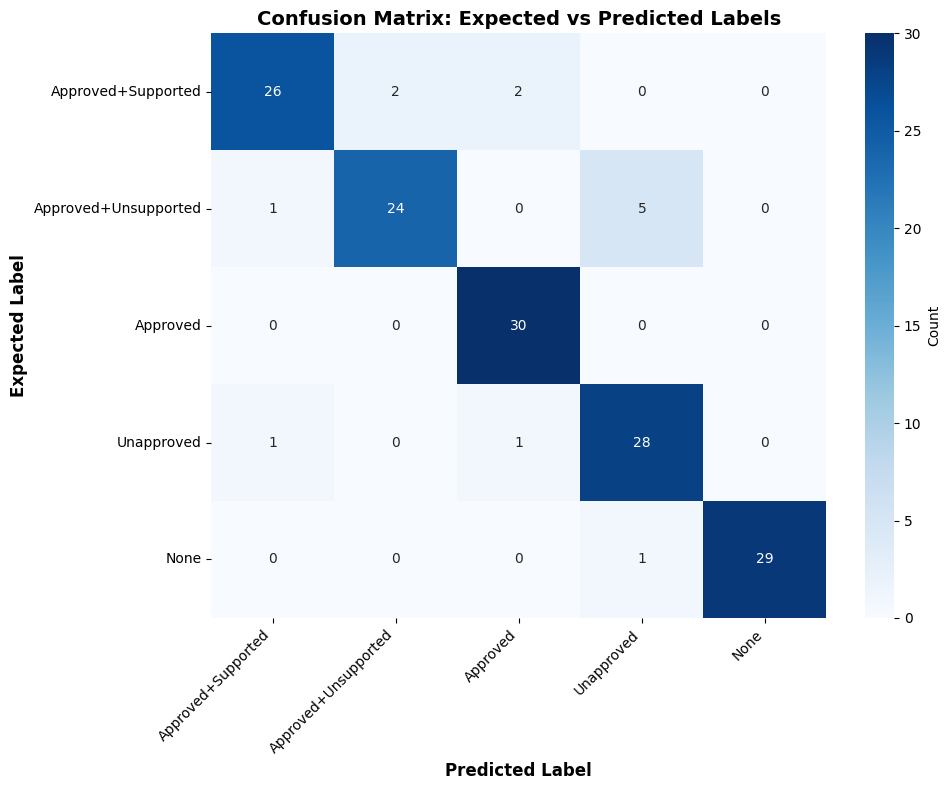


Per-class Accuracy:
  Approved+Supported       : 26/30 = 0.867 (86.7%)
  Approved+Unsupported     : 24/30 = 0.800 (80.0%)
  Approved                 : 30/30 = 1.000 (100.0%)
  Unapproved               : 28/30 = 0.933 (93.3%)
  None                     : 29/30 = 0.967 (96.7%)


In [ ]:
### Confusion Matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get all unique label combinations
all_labels = sorted(set(log_df['expected_labels_str'].unique()) | set(log_df['predicted_labels_str'].unique()))

# Create readable label names
label_names = []
for label_str in all_labels:
    label_list = json.loads(label_str)
    if not label_list:
        label_names.append("None")
    elif label_list == ["drug-approved"]:
        label_names.append("Approved")
    elif sorted(label_list) == ["drug-approved", "supported-claim"]:
        label_names.append("Approved+Supported")
    elif sorted(label_list) == ["drug-approved", "unsupported-claim"]:
        label_names.append("Approved+Unsupported")
    elif label_list == ["drug-unapproved"]:
        label_names.append("Unapproved")
    else:
        label_names.append(str(label_list))

# Create confusion matrix
n = len(all_labels)
confusion_matrix = np.zeros((n, n), dtype=int)

for pred_str, exp_str in zip(log_df['predicted_labels_str'], log_df['expected_labels_str']):
    pred_idx = all_labels.index(pred_str)
    exp_idx = all_labels.index(exp_str)
    confusion_matrix[exp_idx, pred_idx] += 1

# Print numerical confusion matrix
print("Confusion Matrix (rows=expected, columns=predicted):")
print("=" * 80)
confusion_df = pd.DataFrame(confusion_matrix, 
                           index=label_names, 
                           columns=label_names)
print(confusion_df)
print("\n" + "=" * 80)
print(f"Diagonal sum (correct predictions): {np.trace(confusion_matrix)}/{len(log_df)}")

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('Expected Label', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix: Expected vs Predicted Labels', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate per-class accuracy from confusion matrix
print("\nPer-class Accuracy:")
for i, label_name in enumerate(label_names):
    total = confusion_matrix[i, :].sum()
    correct = confusion_matrix[i, i]
    accuracy = correct / total if total > 0 else 0
    print(f"  {label_name:25s}: {correct}/{total} = {accuracy:.3f} ({accuracy*100:.1f}%)")

### Performance Metrics

In [31]:
### Performance Metrics: 

print("Performance Metrics:")
print(f"Average time per post: {log_df['time_seconds'].mean():.2f}s")
print(f"Average memory usage: {log_df['memory_mb'].mean():.2f} MB")
print(f"Average LLM calls: {log_df['llm_calls'].mean():.1f}")
print(f"Average FDA calls: {log_df['fda_calls'].mean():.1f}")
print(f"\nTotals:")
print(f"Total LLM calls: {log_df['llm_calls'].sum()}")
print(f"Total FDA calls: {log_df['fda_calls'].sum()}")

Performance Metrics:
Average time per post: 9.28s
Average memory usage: 0.44 MB
Average LLM calls: 2.0
Average FDA calls: 1.4

Totals:
Total LLM calls: 301
Total FDA calls: 215


### Error Analysis

In [30]:
# Performance for posts with vs without claims
print("\n" + "=" * 80)
print("PERFORMANCE BY CLAIM STATUS")
print("=" * 80)

has_claim_df = log_df[log_df['has_claim'] == True]
no_claim_df = log_df[log_df['has_claim'] == False]

print(f"\nPosts WITH claims ({len(has_claim_df)} posts):")
print(f"  Average time: {has_claim_df['time_seconds'].mean():.2f}s")
print(f"  Average LLM calls: {has_claim_df['llm_calls'].mean():.2f}")
print(f"  Average FDA calls: {has_claim_df['fda_calls'].mean():.2f}")

print(f"\nPosts WITHOUT claims ({len(no_claim_df)} posts):")
print(f"  Average time: {no_claim_df['time_seconds'].mean():.2f}s")
print(f"  Average LLM calls: {no_claim_df['llm_calls'].mean():.2f}")
print(f"  Average FDA calls: {no_claim_df['fda_calls'].mean():.2f}")


PERFORMANCE BY CLAIM STATUS

Posts WITH claims (54 posts):
  Average time: 14.82s
  Average LLM calls: 3.17
  Average FDA calls: 2.26

Posts WITHOUT claims (96 posts):
  Average time: 6.16s
  Average LLM calls: 1.35
  Average FDA calls: 0.97


In [29]:
# Time distribution
print("\n" + "=" * 80)
print("TIME DISTRIBUTION")
print("=" * 80)

# Categorize posts by processing time
log_df['time_category'] = pd.cut(log_df['time_seconds'], 
                                  bins=[0, 5, 10, 15, 20, float('inf')],
                                  labels=['<5s', '5-10s', '10-15s', '15-20s', '>20s'])

time_dist = log_df['time_category'].value_counts().sort_index()
print("\nPosts by processing time:")
for category, count in time_dist.items():
    pct = (count / len(log_df)) * 100
    print(f"  {category}: {count} posts ({pct:.1f}%)")


TIME DISTRIBUTION

Posts by processing time:
  <5s: 34 posts (22.7%)
  5-10s: 57 posts (38.0%)
  10-15s: 37 posts (24.7%)
  15-20s: 15 posts (10.0%)
  >20s: 7 posts (4.7%)


### Error Analysis

In [41]:
### Error Analysis

# Create error dataset
incorrect = log_df[log_df['is_correct'] == False].copy()

# Add error type classification
error_types = []
for idx, row in incorrect.iterrows():
    exp_set = set(row['expected_labels_list'])
    pred_set = set(row['predicted_labels_list'])
    
    fp_labels = pred_set - exp_set
    fn_labels = exp_set - pred_set
    
    if len(fp_labels) > 0 and len(fn_labels) == 0:
        error_types.append("False Positive")
    elif len(fn_labels) > 0 and len(fp_labels) == 0:
        error_types.append("False Negative")
    else:
        error_types.append("Wrong Labels")

incorrect['error_type'] = error_types

# Select relevant columns for error analysis
error_dataset = incorrect[[
    'source', 'input', 'expected_labels', 'predicted_labels', 
    'error_type', 'drugs_detected', 'has_claim', 'claim_text',
    'time_seconds', 'llm_calls', 'fda_calls'
]].copy()

# Save to CSV in output directory
error_dataset.to_csv('outputs/error_analysis.csv', index=False)

print(f"Error dataset created with {len(error_dataset)} errors")
print(f"Saved to: analysis/outputs/error_analysis.csv")
print("\nError breakdown:")
print(error_dataset['error_type'].value_counts())

Error dataset created with 13 errors
Saved to: analysis/outputs/error_analysis.csv

Error breakdown:
error_type
Wrong Labels      10
False Negative     2
False Positive     1
Name: count, dtype: int64
